In [1]:
!pip install datasets transformers sentencepiece accelerate -q
!pip install scikit-learn --upgrade

In [2]:
from datasets import get_dataset_config_names

domains=get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [3]:
from datasets import load_dataset
subjqa=load_dataset("subjqa",name='electronics')

In [4]:
print(subjqa['train']['answers'][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [5]:
import pandas as pd

dfs={split: dset.to_pandas() for split,dset in subjqa.flatten().items()}

for split,df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")


Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [6]:
qa_cols=['title','question','answers.text','answers.answer_start','context']
sample_df=dfs['train'][qa_cols].sample(2,random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [7]:
start_idx=sample_df['answers.answer_start'].iloc[0][0]
end_idx=start_idx+len(sample_df['answers.text'].iloc[0][0])
sample_df['context'].iloc[0][start_idx:end_idx]

'this keyboard is compact'

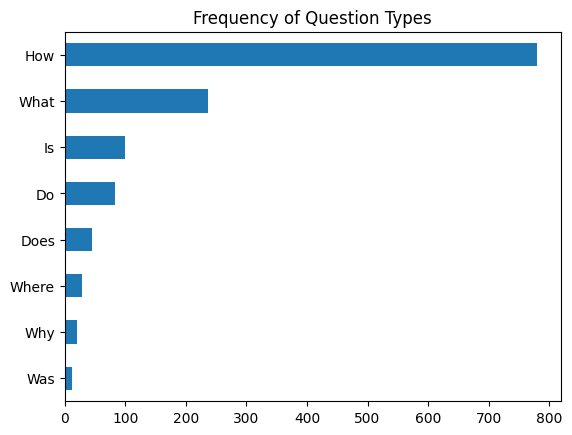

In [8]:
import matplotlib.pyplot as plt

counts={}
question_types=['What','How','Is','Does','Do','Was','Where','Why']

for q in question_types:
    counts[q]=dfs['train']['question'].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()



In [9]:
for question_type in ['How','What','Is']:
    for question in (
        dfs['train'][dfs['train'].question.str.startswith(question_type)]
        .sample(n=3,random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


#Extracting Answers from Text

- Frame the supervised learning problem
- Tokenize and encode text for QA tasks
- Deal with long passages that exceed a model's maximum context size

### Span Classification

- Most common way to extract answers from text is by framing the porblem as a span classification task, where the start and end tokens of an answer span act as the labels that a model needs to predict



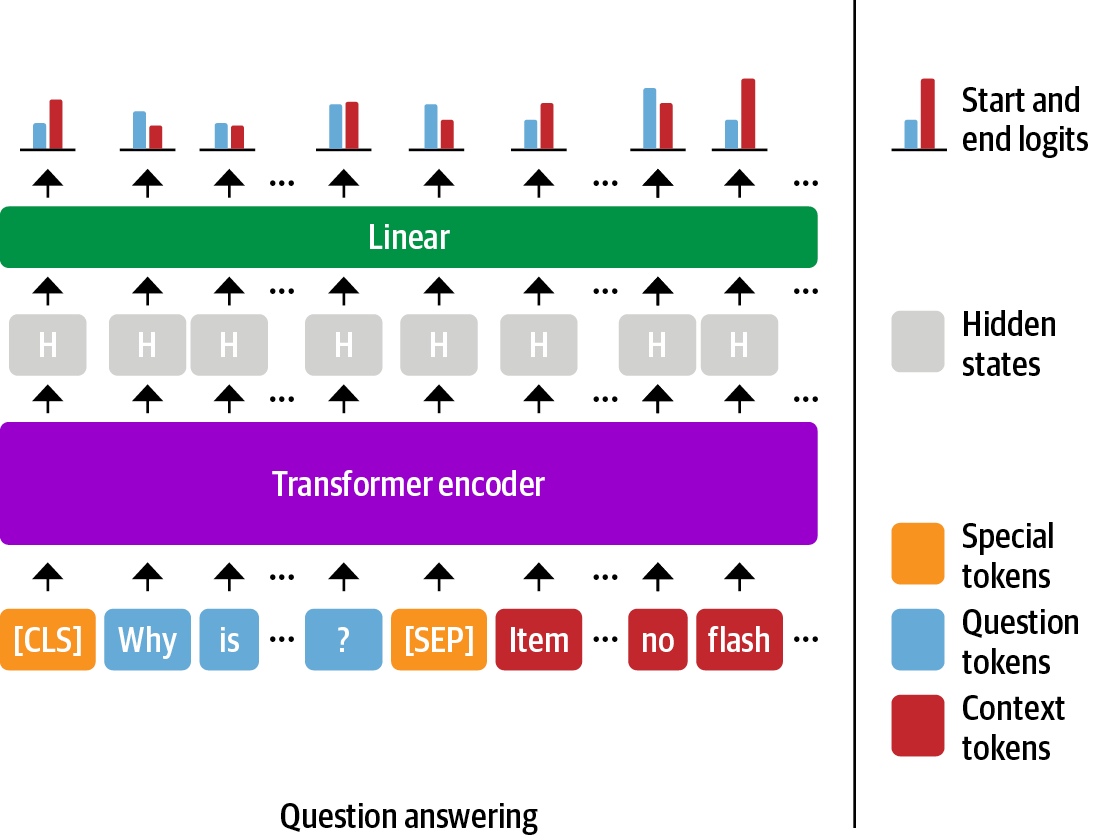

In [10]:
from transformers import  AutoTokenizer

model_ckpt="deepset/minilm-uncased-squad2"
tokenizer=AutoTokenizer.from_pretrained(model_ckpt)


In [11]:
question="How much music can this hold?"
context="""
An MP# is about 1MB/minute, so about 6000 hours depending on file size.
"""

inputs=tokenizer(question,context,return_tensors='pt')

In [12]:
print(tokenizer.decode(inputs['input_ids'][0]))

[CLS] how much music can this hold? [SEP] an mp # is about 1mb / minute, so about 6000 hours depending on file size. [SEP]


In [13]:
import torch
from transformers import AutoModelForQuestionAnswering

model=AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs=model(**inputs)
print(outputs)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[ 1.7627, -5.2762, -5.7905, -5.3906, -5.5060, -5.8739, -5.2696, -6.5243,
          1.7627, -0.4839,  0.2375, -1.1819, -2.1969,  3.1938,  3.5504, -3.9401,
         -4.7159, -2.6179, -5.1319, -1.4217,  3.7794,  4.5681, -0.5047, -3.6367,
         -5.4666, -2.3854, -3.6333, -4.3608,  1.7627]]), end_logits=tensor([[ 1.9853, -5.8393, -5.3206, -5.3707, -5.7119, -5.9227, -5.4298, -4.9016,
          1.9852, -4.4776, -1.6492,  0.0102, -5.1159, -3.5019, -2.6105, -1.0012,
         -4.1588,  3.6553,  0.2192, -3.9306, -3.4069,  1.2676,  5.1932, -0.6512,
         -5.5073, -3.4533,  0.9701,  0.8371,  1.9852]]), hidden_states=None, attentions=None)


In [14]:
start_logits=outputs.start_logits
end_logits=outputs.end_logits

In [15]:
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 29])
Start logits shape: torch.Size([1, 29])
End logits shape: torch.Size([1, 29])


In [16]:
import torch

start_idx=torch.argmax(start_logits)
end_idx=torch.argmax(end_logits)+1
answer_span=inputs["input_ids"][0][start_idx:end_idx]
answer=tokenizer.decode(answer_span)
print(f"Question:{question}")
print(f"Answwr:{answer}")

Question:How much music can this hold?
Answwr:6000 hours


In [17]:
from transformers import pipeline

pipe=pipeline("question-answering",model=model,tokenizer=tokenizer)
pipe(question=question,context=context,topk=3)


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/question_answering.py:326: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.34934380650520325,
  'start': 38,
  'end': 48,
  'answer': '6000 hours'},
 {'score': 0.15876197814941406,
  'start': 32,
  'end': 48,
  'answer': 'about 6000 hours'},
 {'score': 0.12626370787620544,
  'start': 17,
  'end': 48,
  'answer': '1MB/minute, so about 6000 hours'}]

In [18]:
pipe(question="Qhy is there no data?",context=context,handle_impossible_answer=True)

{'score': 0.987058699131012, 'start': 0, 'end': 0, 'answer': ''}

- For other tasks like text classification we can truncate long texts under the assumption that enough information was contained in the embedding of the [CLS] token to generate accurate predictions. For QA, however, this strategy is problematic because the answer to a question could lie near the end of the context and thus would be removed by truncation.

- Standard way to deal with long text size is to apply a **sliding window **across the inputs, where each window contains a passage of tokens in the models context:




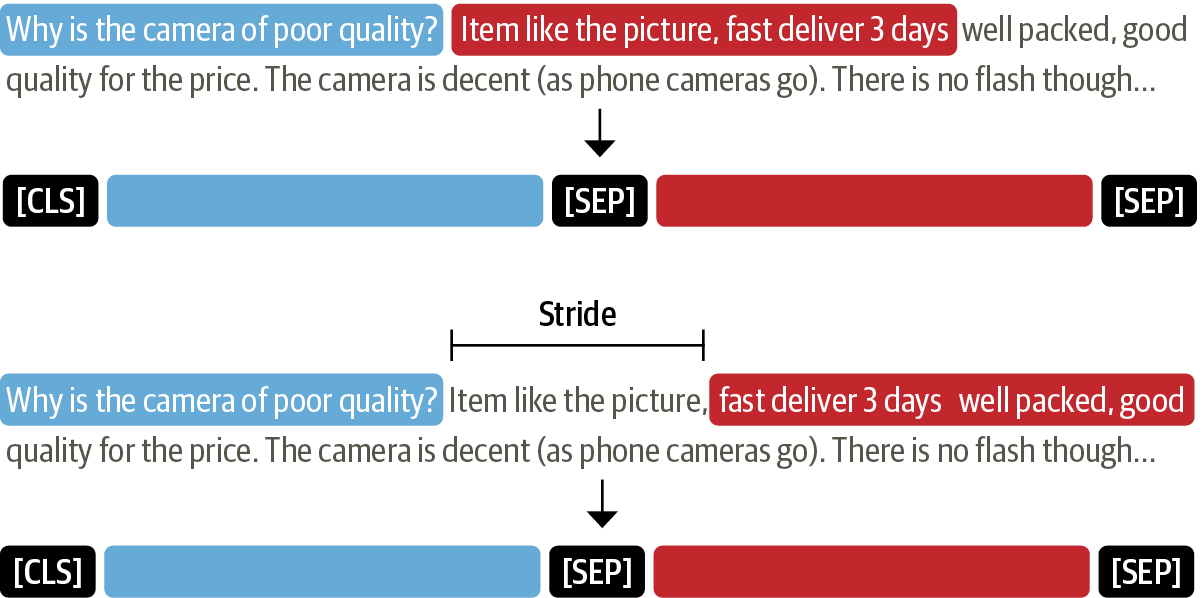

### *How the sliding window creates multiple question-context pairs for long documents- the first bar corresponds to the question, while the second bar is the context captured in each window*

In [19]:
example=dfs['train'].iloc[0][['question','context']]
tokenized_example=tokenizer(example['question'],example['context'],return_overflowing_tokens=True,max_length=100,stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [20]:
for idx, window in enumerate(tokenized_example['input_ids']):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [21]:
for window in tokenized_example['input_ids']:
    print(f"{tokenizer.decode(window)}. \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP]. 

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP]. 



## Using Haystack to Build a QA Pipeline

- In our simple answer extraction example, we provided both the question and the context to the model. However, in reality our system's users will only provide a question about a product, so we need some way of selecting relevant passages from among all the reviews in our corpus.

- One way to do this would be to concatenate all the reviews of a given product together and feed them to the model as a single, long context.

    - Although simple, the drawback of this approach is that the context can become extremely long and thereby introduce an unacceptable latency for out users queries.

    - To handle this, modern QA systems are typically based on the retriever-reader architecture which has two main components:

    1. **Retriever**
        Responsible for retrieving relevant documents for a given query.Retriever are usually categorized as sparse or dense. Sparse retrievers use word frequencies to represent each document is then determined by computing an inner product of the vectors.

        On the other hand, dense retrivers use encoders liketransformers to represent the query and document as contextualized embeddings (which are dense vectors)

        These embeddings encode semantice meaning and allow dense retrievers to imporve search accuracy by understanding the content of the query

    2. **Reader**
        Responsible for extracting an answer from the documents provided by the retriever.The reader is usually a reading comprehension model althoguh at the end o the chapter we'll see examples of mdoels that can genrate free-form answer

- In addition to retriever and reader there are two more components involved when building a QA pipeline with Haystack:

    Document store
        - A document oriented databae that sotres documents and metadata which are provided to the retriever at query time

    Pipeline
        - Combines all. the components of a QA system to enable custom query flows, margin documents from multiple retrievers,and more

In [22]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

In [23]:
import os
from subprocess import Popen, PIPE, STDOUT

# Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
                  stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# Wait until Elasticsearch has started
!sleep 30

In [24]:
!curl -X GET "localhost:9200/?pretty"


curl: (7) Failed to connect to localhost port 9200 after 0 ms: Connection refused


## Haystack

- FARMReader
    - Based on deepset's FARM framework for finetuning and deployign transfromers. Compatible with model trained using hf.


- TransformerReader
    - Based on the QA Pipeline from HF Transformers. Suitable for running inference only


Although both readers handle amodels weights in the same ,way there are some differences in thw way the predictions are converted. to produce answers:

- In Transformers, the QA pipileine normalizes the start and end logits with a softmax in each passage.
    - This means that it is only meaningful to compare answer scores between answers extracgted from the same passage, where the probabilities sum to 1

    - For example an answer score of 0.9 from one passage is nnot necessarily better than a score of 0.8 in another.


    - In Farm, the logits are not normalized, so inter-passage answers can be compared more easily

- The TransformerReaer sometiemz predicts the same answer twice, but with different scores. This can happen in long contexts if the answer lies across two overlapping windows. In FARM, these duplicates are removed

In [25]:
from haystack.document_stores import ElasticsearchDocumentStore

# Return the document embedding for later use with dense retriever
document_store = ElasticsearchDocumentStore(return_embedding=True)

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/elastic_transport/_transport.py", line 329, in perform_request
    meta, raw_data = node.perform_request(
  File "/usr/local/lib/python3.10/dist-packages/elastic_transport/_node/_http_urllib3.py", line 199, in perform_request
    raise err from None
elastic_transport.ConnectionError: Connection error caused by: NewConnectionError(<urllib3.connection.HTTPConnection object at 0x7c33ea68ad70>: Failed to establish a new connection: [Errno 111] Connection refused)
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/elastic_transport/_transport.py", line 329, in perform_request
    meta, raw_data = node.perform_request(
  File "/usr/local/lib/python3.10/dist-packages/elastic_transport/_node/_http_urllib3.py", line 199, in perform_request
    raise err from None
elastic_transport.ConnectionError: Connection error caused by: NewConnectionError(<urllib3.connection.HTTPConnection obj

ConnectionError: ignored

## Dense Passage Retrieval

- We've seen that we get almost perfect recall when our sparse retriever returns k=10 documents, but can we do better at smaller values of k?
- The advantage of doing so is that we can pass fewer documents to the reader and thereby reduce the overall latency of our QA pipeline


- A well known limitation of sparse retrivevers like BM25 is that they can fail to capture the relevant documents if the user query contains terms that dont match exctly those of the review.

- One promising alternative is to use dense embeddings to represent the question and document, and the current state of the art in an architecture known as Dense. Passage Retrieveal (DPR)

    - The main idea behind is to use two BERT models as encoders for the qeustion and the passage.

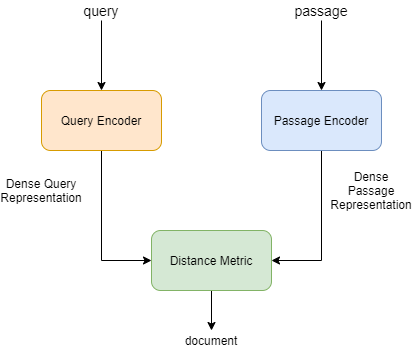

#### **DPR's bi-encoder architecture for computing the relevance of a document and query**

Where distance Metric could be:
- Cosine Similarity, Dot Product Similarity, Euclidean etc.


In [ ]:
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents("document")
    document_store.delete_documents("label")

In [ ]:
from haystack.retriever.sparse import ElasticsearchRetriever

es_retriever=ElasticsearchRetriever(document_store=document_store)

In [ ]:

for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [{"text": row["context"],
             "meta":{"item_id": row["title"], "question_id": row["id"],
                     "split": split}}
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(docs, index="document")

print(f"Loaded {document_store.get_document_count()} documents")

In [ ]:

from haystack.retriever.sparse import ElasticsearchRetriever

es_retriever = ElasticsearchRetriever(document_store=document_store)


item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = es_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

In [ ]:
from haystack.reader.farm import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride,
                    return_no_answer=True)

In [ ]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))


In [ ]:
from haystack.pipeline import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, es_retriever)

In [ ]:
n_answers = 3
preds = pipe.run(query=query, top_k_retriever=3, top_k_reader=n_answers,
                 filters={"item_id": [item_id], "split":["train"]})

print(f"Question: {preds['query']} \n")
for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx]['answer']}")
    print(f"Review snippet: ...{preds['answers'][idx]['context']}...")
    print("\n\n")


In [ ]:

from haystack.pipeline import Pipeline
from haystack.eval import EvalDocuments

class EvalRetrieverPipeline:
    def __init__(self, retriever):
        self.retriever = retriever
        self.eval_retriever = EvalDocuments()
        pipe = Pipeline()
        pipe.add_node(component=self.retriever, name="ESRetriever",
                      inputs=["Query"])
        pipe.add_node(component=self.eval_retriever, name="EvalRetriever",
                      inputs=["ESRetriever"])
        self.pipeline = pipe


pipe = EvalRetrieverPipeline(es_retriever)

In [ ]:

from haystack import Label

labels = []
for i, row in dfs["test"].iterrows():
    # Metadata used for filtering in the Retriever
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # Populate labels for questions with answers
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                question=row["question"], answer=answer, id=i, origin=row["id"],
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False)
            labels.append(label)
    # Populate labels for questions without answers
    else:
        label = Label(
            question=row["question"], answer="", id=i, origin=row["id"],
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True)
        labels.append(label)


In [ ]:
print(labels[0])


In [ ]:
document_store.write_labels(labels, index="label")
print(f"""Loaded {document_store.get_label_count(index="label")} \
question-answer pairs""")


In [ ]:

labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

In [ ]:
print(labels_agg[109])


In [ ]:

def run_pipeline(pipeline, top_k_retriever=10, top_k_reader=4):
    for l in labels_agg:
        _ = pipeline.pipeline.run(
            query=l.question,
            top_k_retriever=top_k_retriever,
            top_k_reader=top_k_reader,
            top_k_eval_documents=top_k_retriever,
            labels=l,
            filters={"item_id": [l.meta["item_id"]], "split": ["test"]})

In [ ]:

run_pipeline(pipe, top_k_retriever=3)
print(f"Recall@3: {pipe.eval_retriever.recall:.2f}")

In [ ]:

#hide_output
def evaluate_retriever(retriever, topk_values = [1,3,5,10,20]):
    topk_results = {}

    for topk in topk_values:
        # Create Pipeline
        p = EvalRetrieverPipeline(retriever)
        # Loop over each question-answers pair in test set
        run_pipeline(p, top_k_retriever=topk)
        # Get metrics
        topk_results[topk] = {"recall": p.eval_retriever.recall}

    return pd.DataFrame.from_dict(topk_results, orient="index")


es_topk_df = evaluate_retriever(es_retriever)

In [ ]:

def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()

plot_retriever_eval([es_topk_df], ["BM25"])

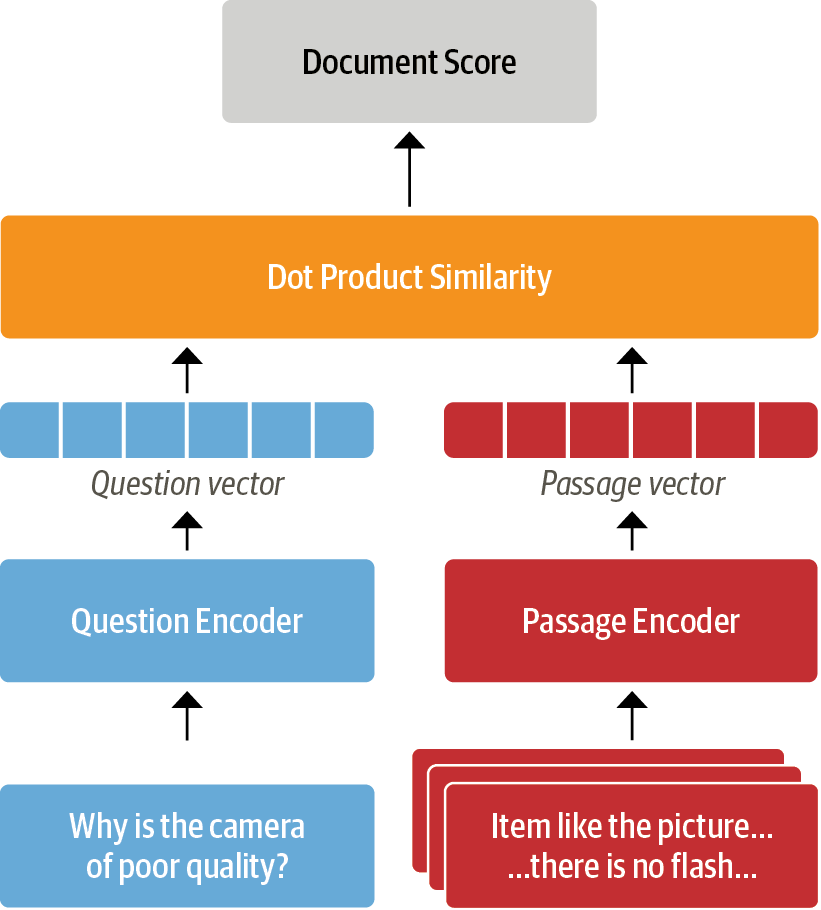

In [ ]:

#hide_output
from haystack.retriever.dense import DensePassageRetriever

dpr_retriever = DensePassageRetriever(document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False)

In [ ]:
document_store.update_embeddings(retriever=dpr_retriever)


In [ ]:

dpr_topk_df = evaluate_retriever(dpr_retriever)
plot_retriever_eval([es_topk_df, dpr_topk_df], ["BM25", "DPR"])

In [ ]:

from farm.evaluation.squad_evaluation import compute_f1, compute_exact

pred = "about 6000 hours"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

In [ ]:

pred = "about 6000 dollars"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

In [ ]:

#hide_output
from haystack.eval import EvalAnswers

def evaluate_reader(reader):
    score_keys = ['top_1_em', 'top_1_f1']
    eval_reader = EvalAnswers(skip_incorrect_retrieval=False)
    pipe = Pipeline()
    pipe.add_node(component=reader, name="QAReader", inputs=["Query"])
    pipe.add_node(component=eval_reader, name="EvalReader", inputs=["QAReader"])

    for l in labels_agg:
        doc = document_store.query(l.question,
                                   filters={"question_id":[l.origin]})
        _ = pipe.run(query=l.question, documents=doc, labels=l)

    return {k:v for k,v in eval_reader.__dict__.items() if k in score_keys}

reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)